In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("../../1. Classification of Myopic Maculopathy/Images/")
path_images = path/"TrainingSet"
path_labels = path/"Lacker"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("TrainingSet","Lacker"))

In [7]:
codes = ['BG','FG']

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),ShiftScaleRotate(),OpticalDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

../../1. Classification of Myopic Maculopathy/Images/TrainingSet/mmac_task_1_train_0549.png


<Axes: >

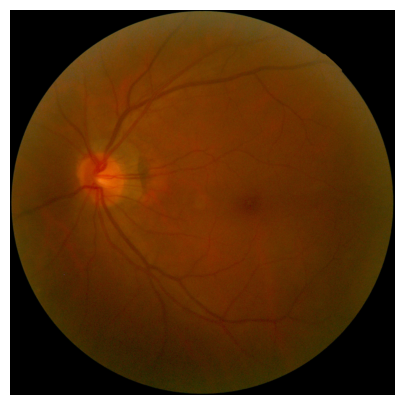

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

../../1. Classification of Myopic Maculopathy/Images/Lacker/mmac_task_1_train_0549.png


In [15]:
# mask = PILMask.create(get_y_fn(img_f))
# mask.show(figsize=(5, 5), alpha=1)

In [16]:
bs = 16

In [17]:
codes

['BG', 'FG']

In [18]:
def my_get_image_files(path):
    return [Path(str(x).replace('Lacker','TrainingSet')) for x in get_image_files(path)]

In [19]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=my_get_image_files,
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

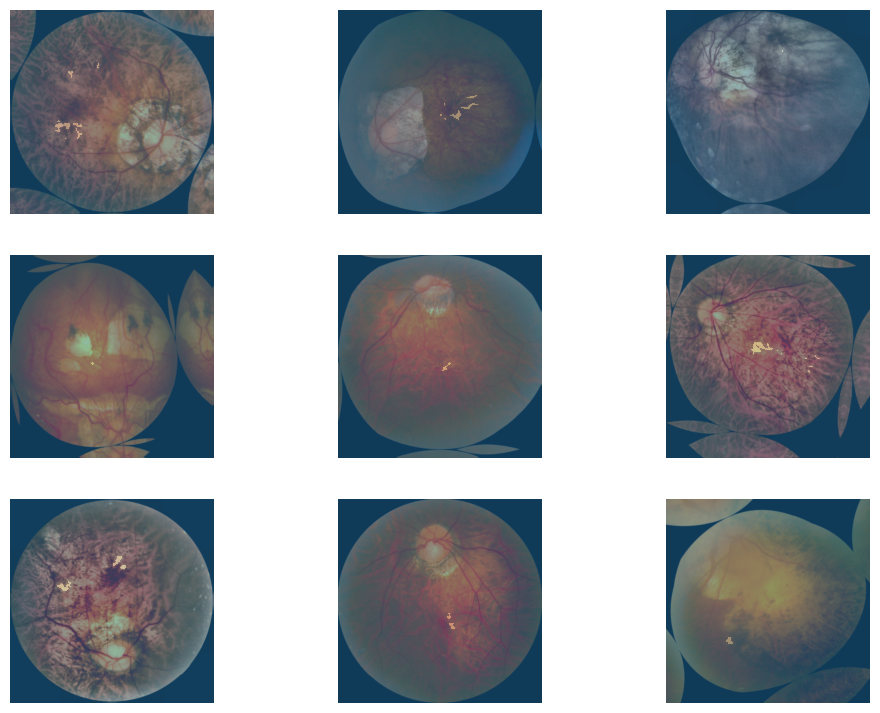

In [20]:
dlsTrain = trainDB.dataloaders(path_labels,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [3]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

KeyError: "Wrong encoder name `xresnet50`, supported encoders: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d', 'timm-mobilenetv3_large_075', 'timm-mobilenetv3_large_100', 'timm-mobilenetv3_large_minimal_100', 'timm-mobilenetv3_small_075', 'timm-mobilenetv3_small_100', 'timm-mobilenetv3_small_minimal_100', 'timm-gernet_s', 'timm-gernet_m', 'timm-gernet_l', 'mit_b0', 'mit_b1', 'mit_b2', 'mit_b3', 'mit_b4', 'mit_b5', 'mobileone_s0', 'mobileone_s1', 'mobileone_s2', 'mobileone_s3', 'mobileone_s4']"

In [22]:
learn = Learner(dlsTrain,model,metrics=[DiceMulti()]).to_fp16()

epoch,train_loss,valid_loss,dice_multi,time
0,0.877357,0.655367,0.499676,00:13
1,0.810976,0.735874,0.460907,00:13
2,0.723254,0.970837,0.459271,00:13
3,0.624821,0.721421,0.492832,00:13
4,0.527507,0.342787,0.499224,00:12
5,0.444115,0.845148,0.493694,00:13
6,0.372926,0.221960,0.497092,00:13
7,0.311680,0.131650,0.499105,00:12
8,0.260198,0.110761,0.499255,00:13
9,0.217089,0.063626,0.498337,00:12


Better model found at epoch 0 with dice_multi value: 0.4996762170733735.


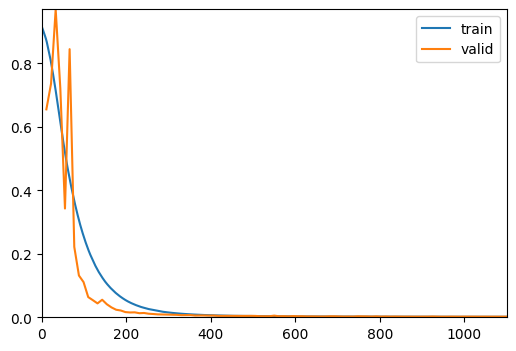

Better model found at epoch 10 with dice_multi value: 0.4996772714574628.
Better model found at epoch 30 with dice_multi value: 0.5003352318132387.
Better model found at epoch 32 with dice_multi value: 0.5046094683838168.
Better model found at epoch 33 with dice_multi value: 0.5052094934006617.
Better model found at epoch 34 with dice_multi value: 0.5218331132543368.
Better model found at epoch 35 with dice_multi value: 0.5222208222529714.
Better model found at epoch 36 with dice_multi value: 0.6138537382027398.
Better model found at epoch 38 with dice_multi value: 0.6782873596427982.
Better model found at epoch 43 with dice_multi value: 0.706886554398179.
Better model found at epoch 47 with dice_multi value: 0.7225711918626723.
Better model found at epoch 51 with dice_multi value: 0.8042147966763876.
Better model found at epoch 58 with dice_multi value: 0.8051804803293359.
Better model found at epoch 64 with dice_multi value: 0.814496787520602.
Better model found at epoch 72 with dice

In [23]:
fname="deeplab-resnet50-semi"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [24]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [25]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [26]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

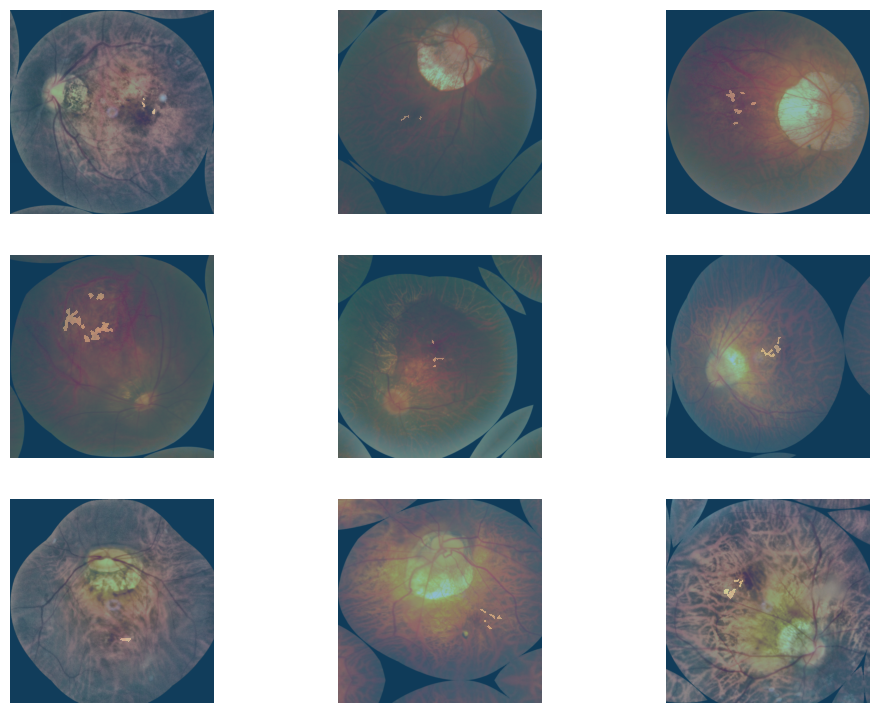

In [27]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [28]:
learn.dls = dlsTrain

epoch,train_loss,valid_loss,dice_multi,time
0,0.006468,0.004300,0.744622,00:06
1,0.006531,0.004226,0.745933,00:06
2,0.006485,0.003924,0.761890,00:06
3,0.006183,0.003639,0.786976,00:06
4,0.006073,0.003517,0.808003,00:06
5,0.005974,0.003405,0.809351,00:06
6,0.005925,0.003475,0.784361,00:06
7,0.005845,0.004551,0.701384,00:06
8,0.005742,0.004868,0.693810,00:06
9,0.005636,0.003998,0.767173,00:06


Better model found at epoch 0 with dice_multi value: 0.744621735413504.


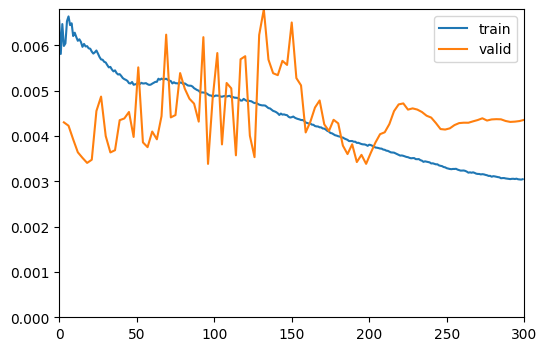

Better model found at epoch 1 with dice_multi value: 0.7459330767050198.
Better model found at epoch 2 with dice_multi value: 0.7618901791971011.
Better model found at epoch 3 with dice_multi value: 0.786976368279488.
Better model found at epoch 4 with dice_multi value: 0.8080030305608328.
Better model found at epoch 5 with dice_multi value: 0.8093509912435762.
Better model found at epoch 31 with dice_multi value: 0.8220451271645852.
Better model found at epoch 64 with dice_multi value: 0.8367350099642465.


In [29]:
fname="deeplab-resnet50-semi-v2"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [30]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'deeplab-lacker-semi.pth')